In [4]:
import os, sys
import numpy as np
import torch

In [2]:
d = os.getcwd()
p = os.path.dirname(d)

sys.path.append(p)

In [3]:
from src.dynamics import RobotWorld
from src.lqr import Lqr
from src.algorithms.dpgpd import Dpgpd
from src.algorithms.adpgpd import ADpgpd
from src.sampling import Sampler

# 1 - Parameters

In [5]:
ds = 4
da = 2

eta = 0.01
tau = 0.5
gamma = 0.9
alpha = 1.0

epochs = 2_000
n_pe = 100
n_rho = 100_000

b = - 70

G1 = - torch.tensor([
    [1.0, 0, 0, 0],
    [0, 1.0, 0, 0],
    [0, 0, .1, 0],
    [0, 0, 0, .1]
])

R1 =  - torch.tensor([
    [0.01, 0],
    [0, 0.01],
]).double()

H = - (tau / 2) * torch.eye(da)

G2 = - torch.tensor([
    [.1, 0, 0, 0],
    [0, .1, 0, 0],
    [0, 0, 1.0, 0],
    [0, 0, 0, 1.0]
])

R2 = - torch.tensor([
    [0.01, 0],
    [0, 0.01],
]).double()

env = RobotWorld(range_pos=[-10., 10.], range_vel=[-.1, .1])
lqr = Lqr(env.A, env.B, gamma)
sampler = Sampler(env, gamma)

# 2 - Solution

In [5]:
P = lqr.calculate_optimal_P(G1, R1)
K = lqr.calculate_optimal_K(R1, P)
opt_lqr = sampler.estimate_V_rho_closed(P, 1_000_000)
print(f"Optimal solution: {opt_lqr}")

Optimal solution: -469.79386196712


In [6]:
dpgpd = Dpgpd(env, eta, tau, gamma, b, G1, G2, R1, R2, H)
_, _, pl_exact, dl_exact = dpgpd.train_constrained(epochs, n_rho)

In [7]:
adpgpd = ADpgpd(env, eta, tau, gamma, b, alpha, G1, G2, R1, R2, H)
_, _, pl_approx, dl_approx = adpgpd.train_constrained(epochs, n_pe, n_rho)

In [8]:
np.save('../results/vel_primal_exact.npy', pl_exact)
np.save('../results/vel_dual_exact.npy', dl_exact)
np.save('../results/vel_primal_approx.npy', pl_approx)
np.save('../results/vel_dual_approx.npy', dl_approx)

# 3 - Varying eta

In [9]:
pl_eta_exact, dl_eta_exact = [], []
etas = [0.1, 0.01, 0.001]
for eta in etas:
    dpgpd = Dpgpd(env, eta, tau, gamma, b, G1, G2, R1, R2, H)
    _, _, pl, dl = dpgpd.train_constrained(epochs, n_rho)
    pl_eta_exact.append(pl), dl_eta_exact.append(dl)
pl_eta_exact, dl_eta_exact = np.array(pl_eta_exact), np.array(dl_eta_exact)

In [10]:
pl_eta_approx, dl_eta_approx = [], []
etas = [0.1, 0.01, 0.001]
for eta in etas:
    adpgpd = ADpgpd(env, eta, tau, gamma, b, alpha, G1, G2, R1, R2, H)
    _, _, pl, dl = adpgpd.train_constrained(epochs, n_pe, n_rho)
    pl_eta_approx.append(pl), dl_eta_approx.append(dl)
pl_eta_approx, dl_eta_approx = np.array(pl_eta_approx), np.array(dl_eta_approx)

In [11]:
np.save('../results/vel_primal_exact_eta.npy', pl_eta_exact)
np.save('../results/vel_dual_exact_eta.npy', dl_eta_exact)
np.save('../results/vel_primal_approx_eta.npy', pl_eta_approx)
np.save('../results/vel_dual_approx_eta.npy', dl_eta_approx)

# 4 - Varying tau

In [ ]:
pl_tau_exact, dl_tau_exact = [], []
taus = [0.1, 0.01, 0.001]
eta = 0.01
for tau in taus:
    H = - (tau / 2) * torch.eye(da)
    dpgpd = Dpgpd(env, eta, tau, gamma, b, G1, G2, R1, R2, H)
    _, _, pl, dl = dpgpd.train_constrained(epochs, n_rho)
    pl_tau_exact.append(pl), dl_tau_exact.append(dl)
pl_tau_exact, dl_tau_exact = np.array(pl_tau_exact), np.array(dl_tau_exact)

In [ ]:
pl_tau_approx, dl_tau_approx = [], []
taus = [0.1, 0.01, 0.001]
eta = 0.01
for tau in taus:
    H = - (tau / 2) * torch.eye(da)
    adpgpd = ADpgpd(env, eta, tau, gamma, b, alpha, G1, G2, R1, R2, H)
    _, _, pl, dl = adpgpd.train_constrained(epochs, n_pe, n_rho)
    pl_tau_approx.append(pl), dl_tau_approx.append(dl)
pl_tau_approx, dl_tau_approx = np.array(pl_tau_approx), np.array(dl_tau_approx)

In [ ]:
np.save('../results/vel_primal_exact_tau.npy', pl_tau_exact)
np.save('../results/vel_dual_exact_tau.npy', dl_tau_exact)
np.save('../results/vel_primal_approx_tau.npy', pl_tau_approx)
np.save('../results/vel_dual_approx_tau.npy', dl_tau_approx)

# 5 - Optimality gap

In [6]:
etas = [0.0005, 0.0002, 0.0001]
epochs = 50_000
n_rho = 1_000_000

V_primal_opt = - 616.0

dg_eta_exact = []
for eta in etas:
    dpgpd = Dpgpd(env, eta, tau, gamma, b, G1, G2, R1, R2, H)
    dg = dpgpd.evaluate_duality_gap(V_primal_opt, epochs, n_rho)
    dg_eta_exact.append(dg)
dg_eta_exact = np.array(dg_eta_exact)

In [9]:
etas = [0.0005, 0.0002, 0.0001]
epochs = 50_000
n_rho = 1_000_000

V_primal_opt = - 616.0

dg_eta_inexact = []
for eta in etas:
    adpgpd = ADpgpd(env, eta, tau, gamma, b, alpha, G1, G2, R1, R2, H)
    dg = adpgpd.evaluate_duality_gap(V_primal_opt, epochs, n_pe, n_rho)
    dg_eta_inexact.append(dg)
dg_eta_inexact = np.array(dg_eta_inexact)

/var/folders/rl/kj05s9097s1_4c4_rglql4y80000gn/T/ipykernel_42276/248451920.py:3: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(dg_eta_inexact[2, :]))


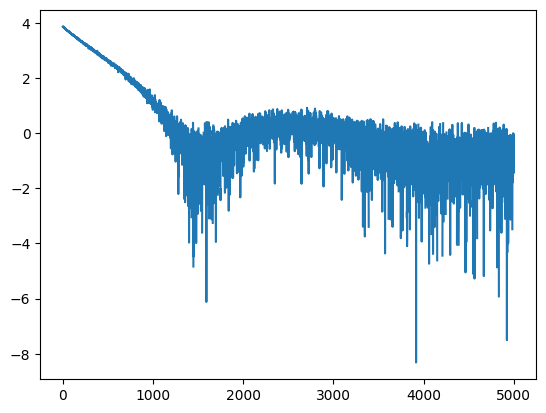

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.log(dg_eta_inexact[0, :]))

In [8]:
np.save('../results/vel_primal_exact_dg.npy', dg_eta_exact)
np.save('../results/vel_primal_inexact_dg.npy', dg_eta_inexact)

In [ ]:
etas = [0.0005, 0.0002, 0.0001]
epochs = 50_000
n_rho = 1_000_000

V_primal_opt = - 616.0
V_dual_opt = b
lmbda_opt = 0.8

dg_eta_exact = []
for eta in etas:
    dpgpd = Dpgpd(env, eta, tau, gamma, b, G1, G2, R1, R2, H)
    dg = dpgpd.evaluate_duality_gap(V_primal_opt, V_dual_opt, lmbda_opt, epochs, n_rho)
    dg_eta_exact.append(dg)
dg_eta_exact = np.array(dg_eta_exact)

In [ ]:
etas = [0.0005, 0.0002, 0.0001]
epochs = 50_000
n_rho = 1_000_000

V_primal_opt = - 616.0
V_dual_opt = b
lmbda_opt = 0.85

dg_eta_inexact = []
for eta in etas:
    adpgpd = ADpgpd(env, eta, tau, gamma, b, alpha, G1, G2, R1, R2, H)
    dg = adpgpd.evaluate_duality_gap(V_primal_opt, V_dual_opt, lmbda_opt, epochs, n_pe, n_rho)
    dg_eta_inexact.append(dg)
dg_eta_inexact = np.array(dg_eta_inexact)

/var/folders/rl/kj05s9097s1_4c4_rglql4y80000gn/T/ipykernel_42276/248451920.py:3: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(dg_eta_inexact[2, :]))


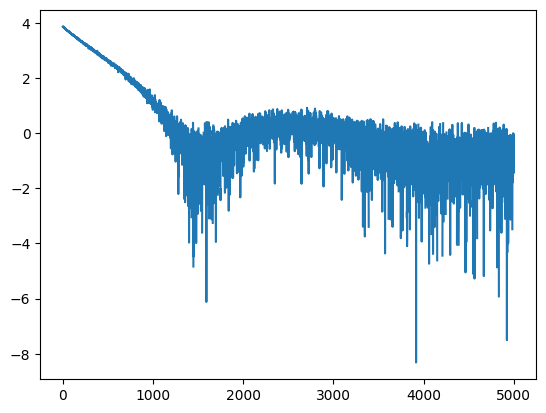

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.log(dg_eta_inexact[2, :]))